# Library

In [38]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Load Data

In [22]:
data = pd.read_csv("bankloan.csv")

In [23]:
data.shape

(700, 9)

In [24]:
data.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1
1,27,1,10,6,31,17.3,1.362202,4.000798,0
2,40,1,15,14,55,5.5,0.856075,2.168925,0
3,41,1,15,14,120,2.9,2.658720,0.821280,0
4,24,2,2,0,28,17.3,1.787436,3.056564,1


## Column Information

1. **age** : usia
2. **ed** : level pendidikan
3. **employ** : lama bekerja
4. **address** : lama tinggal
5. **income** : nominal pendapatan per bulan
6. **debtinc** : persentase hutang dalam income
7. **creddebt** : nominal hutang (satuan : 1000 dolar)
8. **othdebt** : hutang dari sumber yang lain (satuan : 1000 dolar)
9. **default** : 1 adalah default, 0 adalah non default. 

default : peminjam gagal untuk memenuhi kewajiban pembayaran pinjaman sesuai dengan persyaratan yang telah ditetapkan dalam perjanjian pinjaman.

# EDA

In [25]:
data.describe()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,34.860000,1.722857,8.388571,8.278571,45.601429,10.260571,1.553553,3.058209,0.261429
std,7.997342,0.928206,6.658039,6.824877,36.814226,6.827234,2.117197,3.287555,0.439727
min,20.000000,1.000000,0.000000,0.000000,14.000000,0.400000,0.011696,0.045584,0.000000
25%,29.000000,1.000000,3.000000,3.000000,24.000000,5.000000,0.369059,1.044178,0.000000
50%,34.000000,1.000000,7.000000,7.000000,34.000000,8.600000,0.854869,1.987567,0.000000
75%,40.000000,2.000000,12.000000,12.000000,55.000000,14.125000,1.901955,3.923065,1.000000
max,56.000000,5.000000,31.000000,34.000000,446.000000,41.300000,20.561310,27.033600,1.000000


## Concept 1 

Dalam melakukan regresi logistic, yang perlu diperhatikan adalah nilai minimum dan maksimum dari suatu variable. Interpretasi yang dihasilkan akan berada pada interval nilai variable tersebut. 

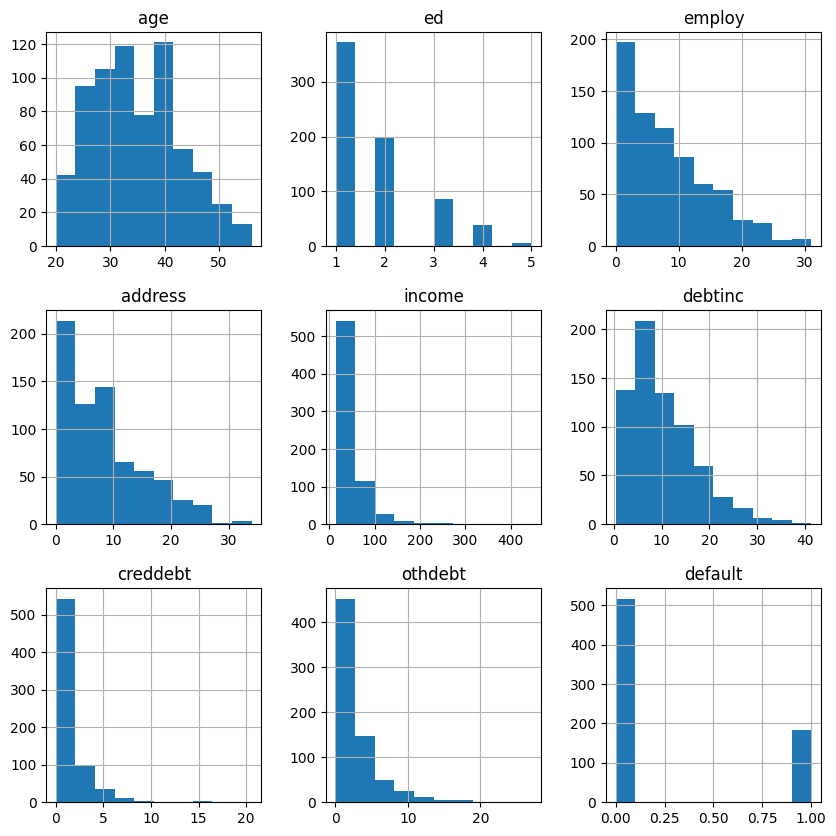

In [26]:
data.hist(figsize = (10, 10))
plt.show()

# Modelling

In [27]:
# split data 

X = data[["employ", "debtinc", "creddebt", "othdebt"]]
y = data[["default"]]

In [28]:
# define model 
model = sm.Logit(y, sm.add_constant(X))

# training
log_reg = model.fit()

Optimization terminated successfully.
         Current function value: 0.411165
         Iterations 7


In [29]:
# summary

print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                  700
Model:                          Logit   Df Residuals:                      695
Method:                           MLE   Df Model:                            4
Date:                Tue, 07 Nov 2023   Pseudo R-squ.:                  0.2844
Time:                        15:03:19   Log-Likelihood:                -287.82
converged:                       True   LL-Null:                       -402.18
Covariance Type:            nonrobust   LLR p-value:                 2.473e-48
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2302      0.236     -5.210      0.000      -1.693      -0.767
employ        -0.2436      0.029     -8.456      0.000      -0.300      -0.187
debtinc        0.0885      0.021      4.200      0.0

## Interpretasi

Variable target dibagi menjadi default (1) dan non default (0). Artinya, yang dimodelkan adalah resiko default atau resiko seseorang pembayarannya akan buruk.

Nilai-nilai yang perlu diperhatikan:
1. LLR p-value = 0.000...2473 < 0.05 (tolak H0). Artinya minimal salah satu variable berpengaruh secara signifikan terhadap resiko default.
1. p-value:

    1. const: 0.000 < 0.05 (tolak H0). Artinya model memerlukan intersep.
    1. employ: 0.000 < 0.05 (tolak H0). Artinya lama kerja berpengaruh secara negatif terhadap resiko default. Semakin lama bekerja, semakin rendah resiko default. Hal ini berlaku untuk employ dengan interval 0 - 31. 
    1. debtinc: 0.000 < 0.05 (tolak H0). Artinya persentase hutang berpengaruh secara positif terhadap resiko default. Semakin besar persentase hutang, semakin tinggi resiko default. Hal ini berlaku untuk debtinc dengan interval 0,4 - 41,3 %.
    1. creddebt: 0.000 < 0.05 (tolak H0). Artinya nominal hutang berpengaruh secara positif terhadap terhadap resiko default. Semakin besar nominal hutang, semakin tinggi resiko default. Hal ini berlaku untuk creddebt dengan interval 0,01 -20,56 (dalam 1000 dollar).
    1. othdebt: 0.94 > 0.05 (terima H0). Tidak cukup bukti bahwa nominal hutang dari sumber lain berpengaruh terhadap resiko default.



## Menghitung ODD-Ratio

In [30]:
# get coefficient

log_reg.params

const      -1.230209
employ     -0.243562
debtinc     0.088460
creddebt    0.504068
othdebt    -0.003981
dtype: float64

In [31]:
# get vars name
vars = log_reg.params.index

# get odd ratio value
for var in vars:
    OR = np.exp(np.abs(log_reg.params[var]) * (15 - 10))
    print(f"OR {var} : {OR}") 

OR const : 469.2072655664398
OR employ : 3.379783667964152
OR debtinc : 1.556284279431629
OR creddebt : 12.4328069692758
OR othdebt : 1.020101889478184


## Interpretasi

Coef :

1. employ: 0,243. Ketika lama kerja meningkat sebesar 5 tahun, kecendrungan seseorang menjadi default menurun sebesar 3,379 kali lipat.
1. debtinc: 0,088. Ketika persentase hutang meningkat sebesar 5%, kecendrungan seseorang menjadi default naik sebesar 1,55 kali lipat.
1. creddebt: 0,504. Ketika nominal hutang meningkat sebesar 5000 dolar, kecendrungan seseorang menjadi default meningkat sebesar 12,43 kali lipat.

Interpretasi diatas hanya berlaku ketika nilai variable lain tidak berubah. Sebagai contoh, ketika nilai debtinc meningkat maka nilai variable lain harus tetap. Kondisi ini yang dinamakan dengan **multikolinearitas**.

## Check Multikolinearitas

In [36]:
def calc(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["vif"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif

In [37]:
calc(X)

,variables,vif
0,employ,2.222753
1,debtinc,3.045977
2,creddebt,2.816577
3,othdebt,4.116876


# Target x Variables

In [32]:
def plot(data, dependent, independent = "default"):
    sns.boxplot(data = data, x = independent, y = dependent)
    plt.show()

vars = [col for col in data.columns if col != "default"]

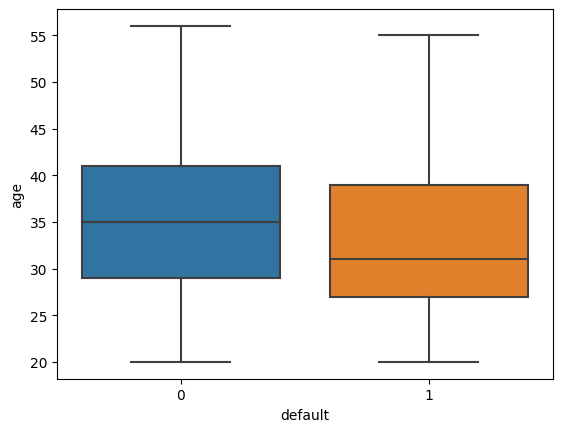

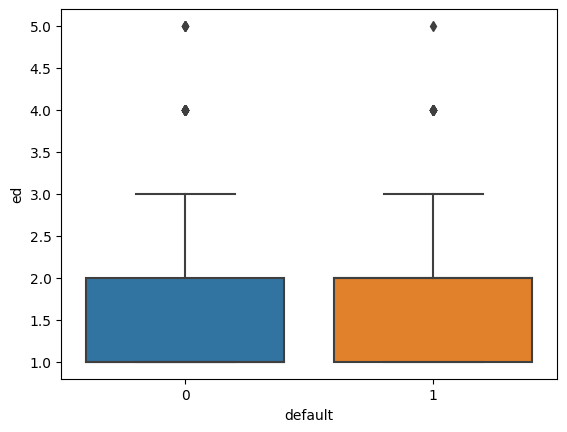

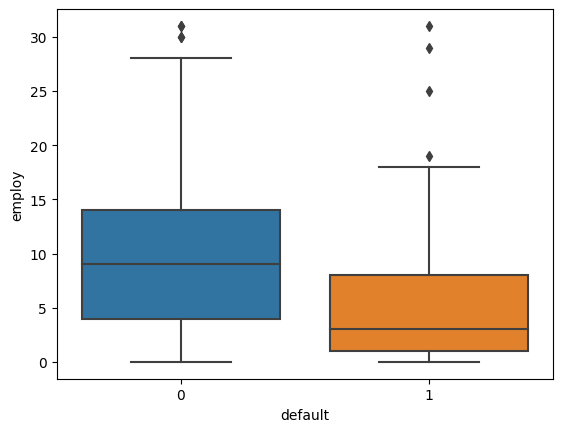

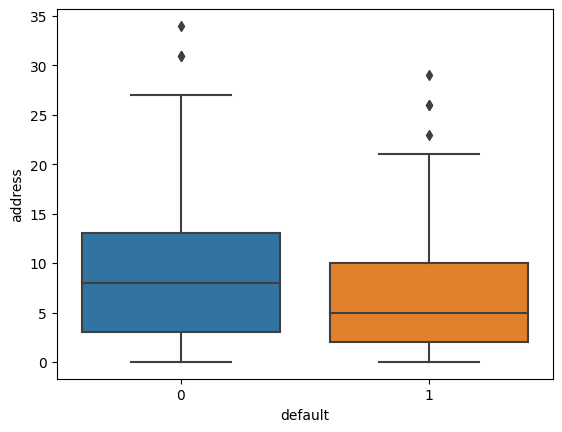

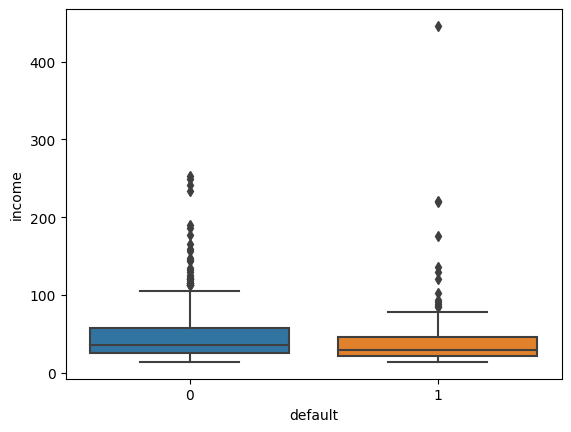

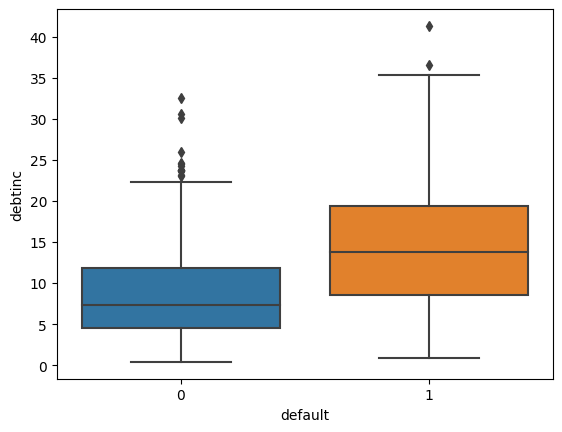

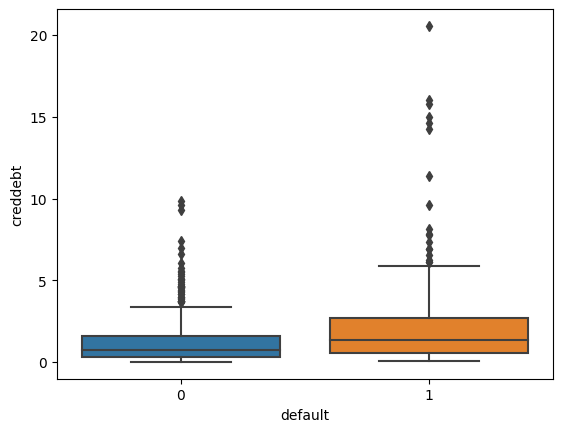

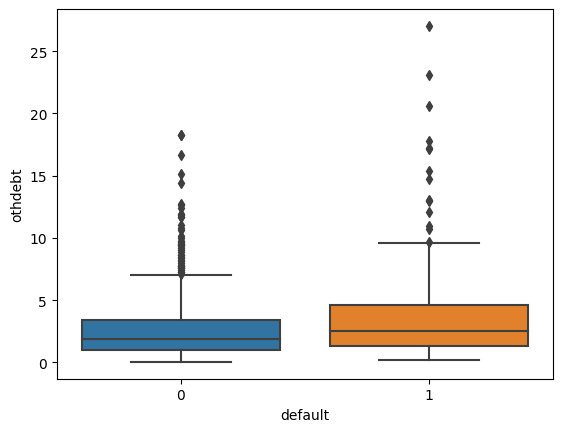

In [33]:
for var in vars:
    plot(data, dependent = var)

# Validasi

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 2023
)

In [40]:
# define model
model = sm.Logit(y_train, sm.add_constant(X_train))

# training
log_reg = model.fit()

Optimization terminated successfully.
         Current function value: 0.406886
         Iterations 7


In [43]:
# predict in x_test
y_test_prob = log_reg.predict(sm.add_constant(X_test))
y_test_class = np.where(y_test_prob > 0.5, 1, 0)

In [44]:
print(f"accuracy_score : {accuracy_score(y_test, y_test_class)}")

accuracy_score : 0.7928571428571428


Jika ada 100 nasabah, maka model akan menghasilkan prediks default/non-default sebanyak 79.